# 1. Install Dependencies and Setup

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        21.4.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.0
cachetools                   5.0.0
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.12
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.6.0
decorator                    5.1.1
defusedxml                   0.7.1
entrypoints                  0.4
executing                    0.8.3
fastjsonschema               2.15.3
flatbuffers                  2.0
fonttools                    4.33.3
gast                         0.5.3
google-auth                  2.6.6
google-auth-oauthlib         0

You should consider upgrading via the 'c:\users\moham\desktop\faseeh\imageclassification\imgcl\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import os

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2779508353626760620
xla_global_id: -1
]


In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
len(gpus)

0

In [7]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [8]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [9]:
data_dir = 'data' 

In [10]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [11]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
data=tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [16]:
data_iterator=data.as_numpy_iterator()

In [17]:
batch=data_iterator.next()

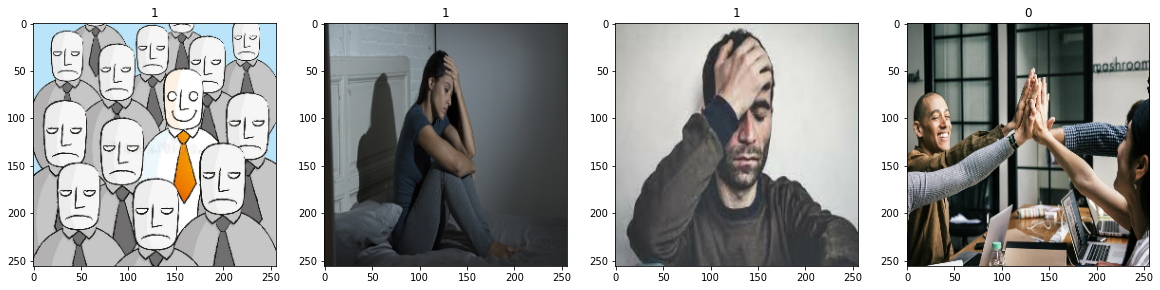

In [18]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data=data.map(lambda x,y:(x/255,y))              

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.25882354, 0.36862746, 0.07843138],
          [0.2521151 , 0.35407588, 0.06780138],
          [0.2317715 , 0.33373228, 0.0553009 ],
          ...,
          [0.922242  , 0.96145767, 0.6808817 ],
          [0.92012984, 0.9619803 , 0.6566999 ],
          [0.91688406, 0.9521782 , 0.63267756]],
 
         [[0.25882354, 0.36862746, 0.07843138],
          [0.24929959, 0.35126036, 0.06498586],
          [0.22883534, 0.33079612, 0.05236475],
          ...,
          [0.92719823, 0.96439385, 0.6949392 ],
          [0.91963845, 0.96148896, 0.66023284],
          [0.9137255 , 0.9517999 , 0.61796874]],
 
         [[0.25436515, 0.36416906, 0.07397299],
          [0.24306832, 0.34502912, 0.0587546 ],
          [0.22745098, 0.32941177, 0.05098039],
          ...,
          [0.9334909 , 0.9680727 , 0.7219133 ],
          [0.92163754, 0.96020985, 0.6767693 ],
          [0.9174326 , 0.9566483 , 0.6161841 ]],
 
         ...,
 
         [[0.5695542 , 0.69112283, 0.4597503 ],
          [0.55482

# 5.Split Data

In [21]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)

In [22]:
train_size

7

In [23]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [24]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model=Sequential()

In [28]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [31]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 8s 917ms/step - loss: 1.1022 - accuracy: 0.4732 - val_loss: 0.6656 - val_accuracy: 0.5469
Epoch 2/20
7/7 [==============================] - 8s 967ms/step - loss: 0.6528 - accuracy: 0.5446 - val_loss: 0.5988 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 7s 911ms/step - loss: 0.6105 - accuracy: 0.6607 - val_loss: 0.5330 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 8s 943ms/step - loss: 0.4918 - accuracy: 0.8036 - val_loss: 0.5694 - val_accuracy: 0.6406
Epoch 5/20
7/7 [==============================] - 8s 923ms/step - loss: 0.4007 - accuracy: 0.8482 - val_loss: 0.2933 - val_accuracy: 0.9219
Epoch 6/20
7/7 [==============================] - 8s 951ms/step - loss: 0.3409 - accuracy: 0.8750 - val_loss: 0.3451 - val_accuracy: 0.7969
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.3385 - accuracy: 0.8795 - val_loss: 0.2333 - val_accuracy: 0.9844
Epoch 8/20
7/7 [=======

# 8. Plot Performance

<function matplotlib.pyplot.show(close=None, block=None)>

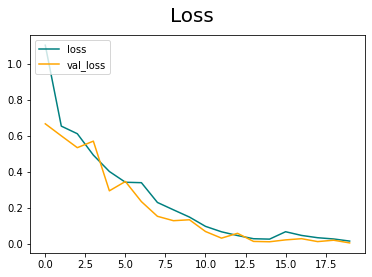

In [36]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

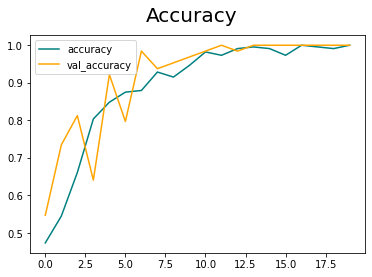

In [38]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show

# 9.Evaluate


In [39]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [40]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [43]:
print(pre.result(),re.result(),acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10.Test

In [44]:
import cv2

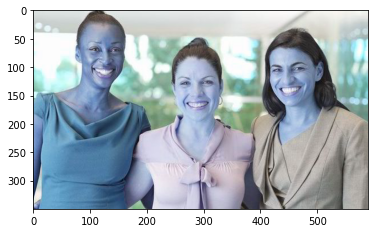

In [47]:
img = cv2.imread('1-2.jpg')
plt.imshow(img)
plt.show()

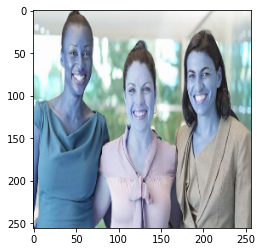

In [48]:
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
yhat=model.predict(np.expand_dims(resize/255,0))

In [50]:
yhat

array([[0.24382779]], dtype=float32)

In [51]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')


Predicted class is Happy


# 11. Save the Model


In [52]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','classifier.h5'))

In [60]:
new_model=load_model('models/classifier.h5')

In [61]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.24382779]], dtype=float32)